# Solve custom optimization probelm with PandaModels.jl

This tutorial describes how to use ***PandaModels*** to create optimization models for custom optimization problems. As shown below, there are 7 steps in total. We will then take "maintaining reactive power flexibility" as an example and describe each step separately. (It is recommended to go through the [tutorial for reactive power optimization](https://github.com/e2nIEE/pandapower/tutorials/pandamodels_reactive%20power%20optimization.ipynb), it will help you understand better.)
<img src="pics/pdm_tutorial.png" alt="ALT" width="400">

## Motivation
The motivation of the examplary case study is providing TSO reactive power flexibility using the reacitve power from  distribution energy resource (DERs) in DSO. The objective is to minimize the deviations of reactive power injection at the TSO-DSO interface from a target value, e.g., $Q_{\rm setpoint}= 2 \rm MVar$. It is formulated by the following equation:

\begin{align}
& \underset{\mathcal{X} = [q, ...]}{\text{minimize}}
& &  \sum_{i\in \mathcal{interfaces}} (Q_i-Q_{\rm setpoint})^2 \\
\end{align}

We use the cigre grid with DERs from the pandapower's network database as test grid. As the picture below shows, the reactive power input at the low voltage side of ***trafo 0*** is the varialbe of interst and observed. It is assumed that a target value for this interface is $Q_{\rm setpoint}= -5 \rm MVAr$, i.e., we optimize the reactive power provision of DER to achieve this target.

<img src="pics/qflex.png" alt="ALT" width="300">

let's create the grid model and add constraints.

In [3]:
import pandapower as pp
import pandapower.networks as nw
from copy import deepcopy

net = nw.create_cigre_network_mv(with_der="pv_wind")
pp.runpp(net) # run power flow calculation

net_opt = deepcopy(net) # copy of the grid for further comparison 
net_opt.load['controllable'] = False
net_opt.sgen['controllable'] = True

# lower and upper bounds for buses
net_opt.bus["max_vm_pu"] = 1.1
net_opt.bus["min_vm_pu"] = 0.9

# lower and upper bounds for external grid
net_opt.ext_grid["max_q_mvar"] = 10000.0
net_opt.ext_grid["min_q_mvar"] = -10000.0
net_opt.ext_grid["max_p_mw"] = 10000.0
net_opt.ext_grid["min_p_mw"] = -10000.0

# lower and upper bounds for DERs
net_opt.sgen["max_p_mw"] = net_opt.sgen.p_mw.values
net_opt.sgen["min_p_mw"] = net_opt.sgen.p_mw.values
net_opt.sgen["max_q_mvar"] = net_opt.sgen.p_mw.values * 0.328
net_opt.sgen["min_q_mvar"] = -net_opt.sgen.p_mw.values * 0.328

# lower and upper bounds for branches
net_opt.trafo["max_loading_percent"] = 100.0
net_opt.line["max_loading_percent"] = 100.0

## 1) Define the variable of interest in the objective function and thier target values

In order to let ***PandaModels*** know the location and target values of the variables of interest in the objective function, we need to mark them in the grid model. To do this, we can add extra column called **"pm_param/custom_name"** in net.trafo and set target values.

**Note**: 

The **"custom_name"** will later be saved in a dictionary (pm.jl) to be read by ***PandaModels*** and used to express the objective function in the optimizaiton model.


In [4]:
net_opt.trafo["pm_param/custom_name"] = None # add extra column
net_opt.trafo["pm_param/custom_name"][0] = -5 #  reactive power setpoint for trafo 0 is -5 MVAR

# Also, we need to tell PandaModels which side is observed.
net_opt.trafo["pm_param/side"] = None
net_opt.trafo["pm_param/side"][0] = "lv" # the observed side is the low-voltage side

## 2) Generate the pm dictionary and check if the first step is correct

In this step, we convert the grid model into the ***PowerModels*** format.

In [5]:
from pandapower.converter import convert_pp_to_pm
pm = convert_pp_to_pm(net_opt)

# now we can check the grid model in PowerModels format.
display(pm)

no costs are given - overall generated power is minimized


{'gen': {'1': {'pg': 0.0,
   'qg': 0.0,
   'gen_bus': 1,
   'vg': 1.03,
   'qmax': 10000.00000001,
   'gen_status': 1,
   'qmin': -10000.00000001,
   'pmin': -10000.00000001,
   'pmax': 10000.00000001,
   'index': 1,
   'startup': 0.0,
   'shutdown': 0.0,
   'model': 2,
   'ncost': 3,
   'cost': [0, 1.0, 0.0]},
  '2': {'pg': 0.02,
   'qg': 0.0,
   'gen_bus': 4,
   'vg': 1.0,
   'qmax': 0.006560010000000001,
   'gen_status': 1,
   'qmin': -0.006560010000000001,
   'pmin': 0.01999999,
   'pmax': 0.020000010000000002,
   'index': 2,
   'startup': 0.0,
   'shutdown': 0.0,
   'model': 2,
   'ncost': 3,
   'cost': [0, 1.0, 0.0]},
  '3': {'pg': 0.02,
   'qg': 0.0,
   'gen_bus': 5,
   'vg': 1.0,
   'qmax': 0.006560010000000001,
   'gen_status': 1,
   'qmin': -0.006560010000000001,
   'pmin': 0.01999999,
   'pmax': 0.020000010000000002,
   'index': 3,
   'startup': 0.0,
   'shutdown': 0.0,
   'model': 2,
   'ncost': 3,
   'cost': [0, 1.0, 0.0]},
  '4': {'pg': 0.03,
   'qg': 0.0,
   'gen_bus': 6

The **"custom_name"** can be found in **"pm["user_defined_params"]"**. When you look at it, you will see that the element indicies are different from the original ones in the grid model. You can find the correspondence through the lookup table **"net_opt._pd2pm_lookups"**.

In [6]:
print("+++++++++++++++++ user defined parameters to be used in optimization models +++++++++++++++++++++++")
display(pm["user_defined_params"])
print("++++++++++++++++++++++++++++++++++++++ lookup table +++++++++++++++++++++++++++++++++++++++++++++++")
display(net_opt._pd2pm_lookups)

+++++++++++++++++ user defined parameters to be used in optimization models +++++++++++++++++++++++


{'custom_name': OrderedDict([(0,
               {'element_index': 16,
                'element_pp_index': 0,
                'value': -5,
                'element': 'trafo',
                'f_bus': 2,
                't_bus': 1})]),
 'side': OrderedDict([(0,
               {'element_index': 16,
                'element_pp_index': 0,
                'value': 'lv',
                'element': 'trafo'})]),
 'gen_and_controllable_sgen': {'2': 2,
  '3': 3,
  '4': 4,
  '5': 5,
  '6': 6,
  '7': 7,
  '8': 8,
  '9': 9,
  '10': 10}}

++++++++++++++++++++++++++++++++++++++ lookup table +++++++++++++++++++++++++++++++++++++++++++++++


{'load': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18]),
 'sgen': array([-1, -1, -1, -1, -1, -1, -1, -1, -1]),
 'storage': array([], dtype=int32),
 'bus': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 'ext_grid': array([1]),
 'gen': array([], dtype=int32),
 'branch': {'line': (1, 16), 'trafo': (16, 18)},
 'aux': {},
 'sgen_controllable': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])}

## 3) Save the pm dictionary in json format

Optimization models are implemented in ***PowerModels*** (Julia Environment). In this step, we save the dictionary ***pm*** as a json file and load it in Julia in the next step.

In [7]:
from pandapower.converter.pandamodels.to_pm import dump_pm_json
pm_file = dump_pm_json(pm, None)
print("the json file for converted net is stored in " + pm_file)

the json file for converted net is stored in C:\Users\zliu\AppData\Local\Temp\pp_to_pm_ixq7v9j5.json


## 4) Load the pm.json file and modify the objective function in PandaModels

In steps 4 and 5 we will operate in the julia environment. It is recommended to download **Visual Studio Code** (VSC), through which we can easily write and test julia files. \
Find the file ***load_custom_pm.jl*** (C:\Users\XXX\\.julia\dev\PandaModels\src\models) and open it in VSC. Then, add the path where ***pm.jl*** is stored and run this file in the debug mode. Now, you will be able to load and check the ***pm*** dictionary in the Julia environment, see below.
<img src="pics/load_custom_pm.png" alt="ALT" width="1000">

## 5) Define a new optimization model in PandaModels

As you know, pandapower and PowerModels belong to different programming environments (Python and Julia).


## 6) Create new function in pandapower and associate the newly create optimization model in the last step
As you know, pandapower and PowerModels belong to different programming environments (Python and Julia).


## 7) Test in pandapower

As you know, pandapower and PowerModels belong to different programming environments (Python and Julia).


We keep the active power for DER constant to the calculated value from the power flow and define a constraint for the reactive power. (In this grid, there is no generator (net.gen))

In [8]:
try:
    pp.runpm_vstab(net_opt)
except Exception as err:
    print(err)    

hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 2.05 seconds:


Also, the following parameters and options can be modified as inputs while calling the optimization from PandaModles. For this case, we can keep the default values.

| parameter | description | type | default |
| :--- | :--- | :---: | :--- |
| correct_pm_network_data | checks if network data is correct. If not tries to correct it | bool | True |
| silence | Suppresses information and warning messages output by PowerModels | bool | True |
| pm_model | PowerModels.jl model to use | str | "ACPPowerModel" |
| pm_solver | "main" solver| str | "ipopt" |
| pm_mip_solver | mixed integer solver| str | "cbc" |
| pm_nl_solver | nonlinear solver| str | "ipopt" |
| pm_tol | default desired convergence tolerance for solver to use | float | 1e-8 |
| pm_log_level | solver log level in power models | int | 0 |
| delete_buffer_file | If True, the .json file used by PandaModels will be deleted after optimization. | bool | True |



### 1-4: Results comparison
Let's check the results for voltage and reactive power at buses connecting DER before and after the optimization.

In [9]:
# results from power flow
display(net_org.res_bus.vm_pu[net_org.sgen.bus])
v_org = net_org.res_bus.vm_pu[net_org.sgen.bus].values
print("--- deviation from setpionts v=0.96 ---")
display(sum((v_org-0.96)**2)) 

3     0.951848
4     0.950094
5     0.948893
6     0.947488
8     0.949187
9     0.948264
10    0.947100
11    0.946916
7     0.952199
Name: vm_pu, dtype: float64

--- deviation from setpionts v=0.96 ---


0.0010976683852842502

In [10]:
# results from optimization
display(net_opt.res_bus.vm_pu[net.sgen.bus])
v_opt = net_opt.res_bus.vm_pu[net_opt.sgen.bus].values
print("--- deviation from setpionts v=0.96 ---")
display(sum((v_opt-0.96)**2)) # devition from setpoints v=0.96 p.u.

3     0.961792
4     0.960087
5     0.958920
6     0.957559
8     0.960321
9     0.959425
10    0.958299
11    0.958119
7     0.964668
Name: vm_pu, dtype: float64

--- deviation from setpionts v=0.96 ---


3.900054027594424e-05

As exected, the bus voltages after optimization are close to the defined setpoints. It is caused by the provision of reactive power of DER.

In [11]:
# results from power flow
display(net_org.res_sgen)

,p_mw,q_mvar
0,0.02,0.0
1,0.02,0.0
2,0.03,0.0
3,0.03,0.0
4,0.03,0.0
5,0.03,0.0
6,0.04,0.0
7,0.01,0.0
8,1.50,0.0


In [12]:
# results from optimization
display(net_opt.res_sgen)

,p_mw,q_mvar
0,0.02,0.006482
1,0.02,0.006497
2,0.03,0.009787
3,0.03,0.009799
4,0.03,0.009752
5,0.03,0.009765
6,0.04,0.013063
7,0.01,0.003228
8,1.50,0.441400


### 1-5: Saving reactive power with multi-objectives
In some situations, users want to improve the voltage profiles with limited reactive power provisions. For this, the objective function is modified by minimizing the reactive power provision. As the formulation below shows, the two sub-objectives for **maintaining voltage setpoints** and **saving reactive power provisions** are connected through coefficients $c_{\rm v}$ and $c_{\rm q}$. 

\begin{align}
& \underset{\mathcal{X} = [q, ...]}{\text{minimize}}
& &  \sum_{i\in \mathcal{BI}} c_{\rm v}*(V_i-V_{\rm setpoint})^2 + c_{\rm q}*(q_i-0)^2 \\
\end{align}

We can call the objective function with different coefficient combinations, e.g., $c_{\rm v}=0.99$ and $c_{\rm q}=0.01$.
(In default, $c_{\rm v}=1.0$ and $c_{\rm q}=0.0$)

In [13]:
net_optlim = deepcopy(net_opt)
net_optlim["obj_factors"] = [0.99, 0.01] # set coefficients for the multi-objective function
try:
    pp.runpm_vstab(net_optlim)
except:
    print("[WinError 3] The system cannot find the path specified to the python39.dll")

hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.06 seconds:


As the results below show, with $c_{\rm v}=0.99$ and $c_{\rm q}=0.01$, the provided reactive powers are reduced, and the corresponding voltages are increased.

In [14]:
print ("--- optimized reactive power without limitation Cv = 1.0, Cq = 0. ----")
display(net_opt.res_sgen) # show optimized reactive power without limitation
print ("--- optimized reactive power with limitation Cv = 0.99, Cq = 0.01 ----")
display(net_optlim.res_sgen) # show optimized reactive power with limitation

print ("--- deviation from setpoints without limitation Cv = 1.0, Cq = 0. ----")
display(sum((v_opt - 0.96) ** 2)) # show optimized reactive power without limitation
print ("--- deviation from setpoints with limitation Cv = 0.99, Cq = 0.01 ----")
v_optlim = net_optlim.res_bus.vm_pu[net_optlim.sgen.bus].values
display(sum((v_optlim - 0.96) ** 2)) # show optimized bus voltages

--- optimized reactive power without limitation Cv = 1.0, Cq = 0. ----


,p_mw,q_mvar
0,0.02,0.006482
1,0.02,0.006497
2,0.03,0.009787
3,0.03,0.009799
4,0.03,0.009752
5,0.03,0.009765
6,0.04,0.013063
7,0.01,0.003228
8,1.50,0.441400


--- optimized reactive power with limitation Cv = 0.99, Cq = 0.01 ----


,p_mw,q_mvar
0,0.02,0.006559
1,0.02,0.006559
2,0.03,0.009839
3,0.03,0.009839
4,0.03,0.009839
5,0.03,0.009839
6,0.04,0.013119
7,0.01,0.003279
8,1.50,0.127064


--- deviation from setpoints without limitation Cv = 1.0, Cq = 0. ----


3.900054027594424e-05

--- deviation from setpoints with limitation Cv = 0.99, Cq = 0.01 ----


0.00043781176800306845

The coefficient combination is grid-dependent. For example, the picture below shows the result for one of our case studies with a realistic grid. The user can find the most suitable combination setting through several attempts.
<img src="pics/coef_combination.png" alt="ALT" width="600">

### 1-6: Time series optimizations
There are two ways to perform time series optimizations. 
The first one is optimization in a loop, i.e., updating the grid condition for each time step and repeatedly calling optimization. The second one uses the "multi-timestep" optimization. PowerModels can solve the multi-grid optimization problem. This feature is used in PandaModels to deal with time series optimization for on specific grid by replacing the "multi-grid" with "multi-timestep" of the grid. 

Next, you will see an example.

First, let's load the time series data.

In [15]:
import pandas as pd

# load time series data for 96 time steps
time_series = pd.read_json("cigre_timeseries_15min.json")
time_series.sort_index(inplace=True)

# show time series
display(time_series) 

# set load type and sgen type in the cigre grid
net["load"].loc[:, "type"] = "residential"
net.sgen.loc[:, "type"] = "pv"
net.sgen.loc[8, "type"] = "wind"

# get rated power
load_p = net["load"].loc[:, "p_mw"].values
sgen_p = net["sgen"].loc[:7, "p_mw"].values
wind_p = net["sgen"].loc[8, "p_mw"]

# create dataframe for loads and sgens
load_ts = pd.DataFrame(index=time_series.index.tolist(), columns=net.load.index.tolist())
sgen_ts = pd.DataFrame(index=time_series.index.tolist(), columns=net.sgen.index.tolist())
for t in range(96):
    load_ts.loc[t] = load_p * time_series.at[t, "residential"]
    sgen_ts.loc[t][:8] = sgen_p * time_series.at[t, "pv"]
    sgen_ts.loc[t][8] = wind_p * time_series.at[t, "wind"]

,timestep,pv,wind,residential
0,0,0.006143,0.622600,0.256022
1,1,0.005877,0.623585,0.248835
2,2,0.005505,0.625056,0.211973
3,3,0.005293,0.625897,0.201825
4,4,0.004921,0.627369,0.209164
...,...,...,...,...
91,91,0.005835,0.921388,0.435660
92,92,0.005423,0.918447,0.410870
93,93,0.004704,0.886837,0.344715
94,94,0.004143,0.858339,0.304026


Now, we perform the time series optimizations in a loop.

In [16]:
########################################################################
####################### Optimization in a loop #########################
########################################################################

y_loop = []
for t in range(96):
    
    # Update operating points for each time step
    net_opt.load.p_mw = load_ts.loc[t]
    net_opt.sgen.p_mw = sgen_ts.loc[t]
    
    # If required, we also need to update the constraints, e.g., Qmax- and Qmin-value, for each time step. 
    net_opt.sgen.max_p_mw = sgen_ts.loc[t]   # for load: max_p_mw == min_p_mw, because they are not controllable.
    net_opt.sgen.min_p_mw = sgen_ts.loc[t]
    net_opt.sgen.max_q_mvar = net_opt.sgen.max_q_mvar
    net_opt.sgen.min_q_mvar = net_opt.sgen.min_q_mvar
    
    # run optimization for time step t
    try:
        pp.runpm_vstab(net_opt)
    except:
        print("[WinError 3] The system cannot find the path specified to the python39.dll")
    
    # save the mean voltage value for each time step
    y_loop.append(net_opt.res_bus.vm_pu[net_opt.sgen.bus].values.mean())

hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.06 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.03 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.03 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.03 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimiza

hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.05 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.05 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.05 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.05 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimiza

hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.05 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.06 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.07 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_vstab') is finished in 0.05 seconds:
hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimiza

Alternatively, we can do it using multi-timestep optimization.

In [17]:
########################################################################
####################### multi-timestep optimization ####################
########################################################################

from pandapower.control import ConstControl
from pandapower.timeseries import DFData

# For this method, we need to add the time series data into the pandapower.controller.
net_opt.controller.drop(net.controller.index, inplace=True) # remove the existing controllers

# Add time series for load and sgen.
ConstControl(net_opt, element="load", variable="p_mw",
             element_index=net.load.index.tolist(), profile_name=net.load.index.tolist(),
             data_source=DFData(load_ts))
ConstControl(net_opt, element="sgen", variable="p_mw",
             element_index=net.sgen.index.tolist(), profile_name=net.sgen.index.tolist(),
             data_source=DFData(sgen_ts))

# If required, we also need to creat a time series for the constraints, e.g., Qmax- and Qmin-value, for each time step. 
df_qmax, df_qmin = sgen_ts.copy(), sgen_ts.copy()
df_qmax[df_qmax.columns] = net_opt.sgen.max_q_mvar
df_qmin[df_qmin.columns] = net_opt.sgen.min_q_mvar

# Then create controllers for them.
ConstControl(net_opt, element="sgen", variable="max_p_mw",
              element_index=net.sgen.index.tolist(), profile_name=net.sgen.index.tolist(),
              data_source=DFData(sgen_ts))
ConstControl(net_opt, element="sgen", variable="min_p_mw",
              element_index=net.sgen.index.tolist(), profile_name=net.sgen.index.tolist(),
              data_source=DFData(sgen_ts))
ConstControl(net_opt, element="sgen", variable="max_q_mvar",
              element_index=net.sgen.index.tolist(), profile_name=net.sgen.index.tolist(),
              data_source=DFData(df_qmax))
ConstControl(net_opt, element="sgen", variable="min_q_mvar",
              element_index=net.sgen.index.tolist(), profile_name=net.sgen.index.tolist(),
              data_source=DFData(df_qmin))

# For the multi-timestep optimization, we need to call another PandaModels-function.
try:
    pp.runpm_multi_vstab(net_opt, from_time_step=0, to_time_step=96)
except:
    print("[WinError 3] The system cannot find the path specified to the python39.dll")

hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_multi_vstab') is finished in 5.88 seconds:


**Note that**, currently, the function ***pp.runpm_multi_vstab()*** doesn't support using of the multi-objective function for saving reactive power.

The results for each time step are saved in **net.res_ts_opt**. Let's get them.

In [18]:
y_multi = []
for t in range(96):
    y_multi.append(net_opt.res_ts_opt[str(t)].res_bus.vm_pu[net_opt.sgen.bus].values.mean())

And then plot them.

Text(0, 0.5, 'mean voltage value for DER-buses [p.u.]')

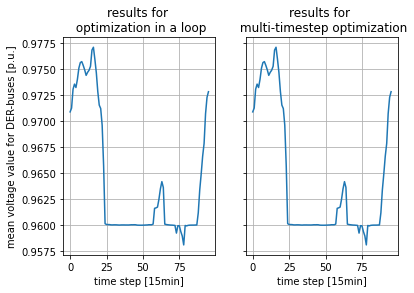

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.plot(range(96), y_loop)
ax1.set_title("results for \n optimization in a loop")
ax2.plot(range(96), y_multi)
ax2.set_title("results for \n multi-timestep optimization")

for ax in ax1, ax2:
    ax.grid(True)
    ax.label_outer()
    ax.set_xlabel("time step [15min]")
ax1.set_ylabel("mean voltage value for DER-buses [p.u.]")

As the plot above shows, both methods have the same results.

**For a long-term time series optimization (>500 timesteps), we suggest using the first method, optimization in a loop.**

## 2) Maintaining Reactive Power Setpoints

The motivation for this objective is to minimize the deviations of reactive power injection at the TSO-DSO interface from a target value, e.g., $Q_{\rm setpoint}= 2 \rm MVar$. It is formulated by the following equation:

\begin{align}
& \underset{\mathcal{X} = [q, ...]}{\text{minimize}}
& &  \sum_{i\in \mathcal{interfaces}} (Q_i-Q_{\rm setpoint})^2 \\
\end{align}

We use the same grid model to introduce the example. As the picture low shows, the marked bus (or interface) is observed.


<img src="pics/qflex.png" alt="ALT" width="300">

First, let's create the grid and check the reactive power injection at this interface.

In [20]:
import pandapower as pp
import pandapower.networks as nw
from copy import deepcopy

net = nw.create_cigre_network_mv(with_der="pv_wind")
pp.runpp(net)
net_org = deepcopy(net)

display(net.res_trafo.q_lv_mvar[0])

-5.941540318632734

Without optimization, the reactive power injection at this interface is -5.942 MVAr.

Let's configure optimization parameters and define a target value for this interface, $Q_{\rm setpoint}= -5 \rm MVAr$, i.e., we optimize the reactive power provision of DER to achieve this target.

In [21]:
net_opt = deepcopy(net) # copy of the grid for further comparison 
net_opt.load['controllable'] = False
net_opt.sgen['controllable'] = True

# lower and upper bounds for buses
net_opt.bus["max_vm_pu"] = 1.1
net_opt.bus["min_vm_pu"] = 0.9

# lower and upper bounds for external grid
net_opt.ext_grid["max_q_mvar"] = 10000.0
net_opt.ext_grid["min_q_mvar"] = -10000.0
net_opt.ext_grid["max_p_mw"] = 10000.0
net_opt.ext_grid["min_p_mw"] = -10000.0

# lower and upper bounds for DERs
net_opt.sgen["max_p_mw"] = net_opt.sgen.p_mw.values
net_opt.sgen["min_p_mw"] = net_opt.sgen.p_mw.values
net_opt.sgen["max_q_mvar"] = net_opt.sgen.p_mw.values * 0.328
net_opt.sgen["min_q_mvar"] = -net_opt.sgen.p_mw.values * 0.328
display(net_opt.sgen)

# lower and upper bounds for lines
net_opt.trafo["max_loading_percent"] = 100.0
net_opt.line["max_loading_percent"] = 100.0

######################################################
####################### Attention ####################
######################################################

# We need to let PandaModels know which interface is of interest and what is user-defined setpoint. 
# So, we need to add extra column called **"pm_param/setpoint_q"** in net.trafo and set target value. 

net_opt.trafo["pm_param/setpoint_q"] = None # add extra column
net_opt.trafo["pm_param/setpoint_q"][0] = -5 #  reactive power setpoint for trafo 0 is -5 MVAR

# Also, we need to tell PandaModels which side is observed.
net_opt.trafo["pm_param/side"] = None
net_opt.trafo["pm_param/side"][0] = "lv" # the observed side is the low-voltage side


,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,controllable,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,PV 3,3,0.02,0.0,0.02,1.0,True,PV,True,True,0.02,0.02,0.00656,-0.00656
1,PV 4,4,0.02,0.0,0.02,1.0,True,PV,True,True,0.02,0.02,0.00656,-0.00656
2,PV 5,5,0.03,0.0,0.03,1.0,True,PV,True,True,0.03,0.03,0.00984,-0.00984
3,PV 6,6,0.03,0.0,0.03,1.0,True,PV,True,True,0.03,0.03,0.00984,-0.00984
4,PV 8,8,0.03,0.0,0.03,1.0,True,PV,True,True,0.03,0.03,0.00984,-0.00984
5,PV 9,9,0.03,0.0,0.03,1.0,True,PV,True,True,0.03,0.03,0.00984,-0.00984
6,PV 10,10,0.04,0.0,0.04,1.0,True,PV,True,True,0.04,0.04,0.01312,-0.01312
7,PV 11,11,0.01,0.0,0.01,1.0,True,PV,True,True,0.01,0.01,0.00328,-0.00328
8,WKA 7,7,1.50,0.0,1.50,1.0,True,WP,True,True,1.50,1.50,0.49200,-0.49200


After parametrization, we can start the optimization using ***pp.runpm_qflex()***.

In [22]:
try:
    pp.runpm_qflex(net_opt)
except:
    print("[WinError 3] The system cannot find the path specified to the python39.dll")

hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_qflex') is finished in 0.03 seconds:


Let's check the optimization results.

In [23]:
display(net_opt.res_trafo.q_lv_mvar[0])  # show Q-injection at the interface after optimization
display(net_opt.res_sgen) # show optimized reactiv power provision of DER

-5.356245826038442

,p_mw,q_mvar
0,0.02,0.00656
1,0.02,0.00656
2,0.03,0.00984
3,0.03,0.00984
4,0.03,0.00984
5,0.03,0.00984
6,0.04,0.01312
7,0.01,0.00328
8,1.50,0.49200


From the results above, we can see that the Q-injection at the interface is closer to the setpoint after the optimization but not achieved. The reason is that the Q-maximum is limited. We can modify the Q-maximum and try again.

In [24]:
net_opt.sgen["max_q_mvar"] = net_opt.sgen.p_mw.values * 0.628
net_opt.sgen["min_q_mvar"] = -net_opt.sgen.p_mw.values * 0.628
try:
    pp.runpm_qflex(net_opt)
except:
    print("[WinError 3] The system cannot find the path specified to the python39.dll")
display(net_opt.res_trafo.q_lv_mvar[0])  # show Q-injection at the interface after optimization
display(net_opt.res_sgen)

hp.pandapower.opf.make_objective - WARNING: no costs are given - overall generated power is minimized
hp.pandapower.opf.run_powermodels - INFO: Optimization ('run_pandamodels_qflex') is finished in 0.02 seconds:


-5.0000000238509115

,p_mw,q_mvar
0,0.02,0.001931
1,0.02,0.001945
2,0.03,0.004184
3,0.03,0.004198
4,0.03,0.004140
5,0.03,0.004168
6,0.04,0.006959
7,0.01,0.000483
8,1.50,0.881054


Now, the Q-injection at the interface is optimized to -5 MVAr. 

Similar to the **maintaining voltage setpoints**, if you are interested in time series optimizations, you can do it through a loop or use ***pp.runpm_multi_qflex()***.

## 3) Active Power Loss Reduction

coming
